In [13]:
import pandas as pd
import numpy as np
import os
from scipy.signal import find_peaks, peak_widths
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [14]:

def calculate_fwhm(column_data):
    # Validate input
    if not isinstance(column_data, (pd.Series, np.ndarray, list)):
        raise ValueError("Input data must be a Pandas Series, list, or numpy array.")

    # Convert to NumPy array if necessary
    data = np.array(column_data)

    # Generate the original x-axis values (indices of the data)
    original_x = np.arange(len(data))

    # Interpolate data with 10 times the original number of points
    interp_factor = 10
    interpolated_x = np.linspace(original_x[0], original_x[-1], len(data) * interp_factor)
    interpolator = interp1d(original_x, data, kind='cubic')
    interpolated_data = interpolator(interpolated_x)

    # Find peaks in the interpolated data
    peaks, _ = find_peaks(interpolated_data)

    # Handle case when no peaks are found
    if len(peaks) == 0:
        return None  # No peaks, return None

    # Identify the largest peak (highest value in `interpolated_data`)
    largest_peak_idx = peaks[np.argmax(interpolated_data[peaks])]

    # Calculate FWHM for the largest peak in the interpolated data
    results_half = peak_widths(interpolated_data, [largest_peak_idx], rel_height=0.5)
    fwhm = results_half[0][0] / interp_factor  # Divide by the interpolation factor to scale back

    return fwhm


def calculate_fwhm_for_columns(csv_file, remove_mid_peaks):
    # Read the CSV file using pandas
    df = pd.read_csv(csv_file)

    # Extract x and y values
    x = df.iloc[:, 0]
    y = df.iloc[:, 1].copy()  # Copy to avoid modifying original


    # Find all peaks and their heights
    peaks, properties = find_peaks(y)
    peak_heights = y[peaks]

    # Keep only peaks ≥ 0.5 * max peak height
    threshold = 0.3 * peak_heights.max()      #Para algunos núcleos funciona mejor 0.3 o 0.5
    filtered_peaks = peaks[peak_heights >= threshold]

    # Then select first and last peak
    if len(filtered_peaks) >= 2 and remove_mid_peaks:
        first_peak = filtered_peaks[0]
        last_peak = filtered_peaks[-1]
        # Get the maximum y value
        ymax = np.amax(y)
        # Replace y values between the first and last peak
        y[first_peak+1:last_peak] = ymax

        plt.plot(x,df.iloc[:, 1], marker='o', linestyle='-', label=csv_file)

    plt.plot(x,y, marker='.', linestyle='-', label=csv_file)
    df.iloc[:, 1] = y
    #plt.legend()

    # Initialize an empty list to store FWHM results for each column
    fwhm_results = []

    ## Iterate through each column in the DataFrame
    #print(csv_file)
    for column in df.columns[1:]:

        ## Extract colum data
        column_data = df[column]

        # Calculate FWHM for the column
        fwhm = calculate_fwhm(column_data)
        print(column, ": ", fwhm)

        # Append the result to the list
        fwhm_results.append(fwhm)

    #print(fwhm_results)
    return fwhm_results



def fwhm(folder_path, NameId, remove_mid_peaks):
    plt.figure(figsize=(8, 6))
    plt.title(NameId)  # Change this to your desired title
    plt.xlabel('Profile position')  # Customize as needed
    plt.ylabel('Intensty')  # Customize as needed
    return [calculate_fwhm_for_columns(os.path.join(folder_path, file), remove_mid_peaks)[-1].astype(np.float32)
            for file
            in os.listdir(folder_path)]



def csv(axial, lateral):
    df = pd.DataFrame({'FWHM_axial': axial, 'FWHM_lateral': lateral})
    df = df.round(5)
    # Guardar en la carpeta base_dir en vez de la carpeta del script
    df.to_csv(os.path.join(base_dir, 'resultados_fwhm_' + n + '.csv'), index=False)




def graficas(axial, lateral):


    # initialize dataframe

    # MSE-GANS-2D
    ngroup = 3
    n_samples_ax = len(axial)
    n_samples_lat = len(lateral)

    # MSE-UNET-2D


    df_0 = pd.DataFrame({'data': axial, 'group': map(np.floor, np.random.rand(n_samples_ax) * 1)})

    column_ax = 'data'
    grouped_ax = df_0.groupby('group')

    names_ax, vals_ax, xs_ax = [], [] ,[]

    mean_shape = dict(markerfacecolor='lightgreen', marker='D', markeredgecolor='black', alpha = 1)

    for i, (name, subdf) in enumerate(grouped_ax):
        names_ax.append(name)
        vals_ax.append(subdf[column_ax].tolist())
        xs_ax.append(np.random.normal(0, 0.02, subdf.shape[0]))

        #xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))


    # -------------------------------------------------------------------------------------------------------- #

    df_1 = pd.DataFrame({'data': lateral, 'group': map(np.floor, np.random.rand(n_samples_lat) * 1)})

    column_lat = 'data'
    grouped_lat = df_1.groupby('group')

    names_lat, vals_lat, xs_lat = [], [] ,[]

    for i, (name, subdf) in enumerate(grouped_lat):
        names_lat.append(name)
        vals_lat.append(subdf[column_lat].tolist())
        xs_lat.append(np.random.normal(1, 0.02, subdf.shape[0]))

        #xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))


    # -------------------------------------------------------------------------------------------------------- #

    ax_max, ax_min = np.max(axial), np.min(axial)
    lat_max, lat_min = np.max(lateral), np.min(lateral)

    y_max = np.max([ax_max, lat_max])
    y_min = np.min([ax_min, lat_min])

    ## EJE Y: Acá se puede setear el tamaño del eje y, esto para que los resultados tengan la misma escala y se pueda comparar visualmente
    ## Esto se puede cambiar según la estructura que está siendo procesada

    ylims = [0, 50]

    plt.figure(figsize=(4,5))
    plt.ylabel('FWHM')
    plt.ylim(ylims)
    plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
    ngroup = len(vals_ax)
    clevels_ax = np.linspace(0., 1., ngroup)

    for x_ax, val_ax, clevel_ax in zip(xs_ax, vals_ax, clevels_ax):
        plt.scatter(x_ax, val_ax, c=['navy'], alpha=0.3)

        #plt.subplot(1,4,3)
    plt.ylim(ylims)
    plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
    ngroup = len(vals_lat)
    clevels_lat = np.linspace(0., 1., ngroup)

    for x_lat, val_lat, clevel_lat in zip(xs_lat, vals_lat, clevels_lat):
        plt.scatter(x_lat, val_lat, c=cm.prism(clevel_lat), alpha=0.3)


    #plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.savefig(os.path.join(base_dir, 'graficas_' + n + '.svg'), dpi=1200)
    plt.close()


def main(axial_path, lateral_path, remove_mid_peaks):

    axial = fwhm(axial_path, 'axial', remove_mid_peaks)
    lateral = fwhm(lateral_path, 'lateral', remove_mid_peaks)

    csv(axial, lateral)

    graficas(axial, lateral)





Procesando: BC_Ch2_SNR_15_RL20
Y :  8.101291293951551
Y :  9.369472682645005
Y :  8.421138810300851
Y :  7.944380605473415
Y :  9.107505911868918
Y :  8.594328177554775
Y :  8.265503061690373
Y :  8.498758795947964
Y :  8.960316473919601
Y :  8.274348915470672
Y :  8.412456300293906
Y :  8.0658837396352
Y :  9.013609955470894
Y :  8.988257829206068
Y :  8.939919558436657
Y :  9.296682002038546
Y :  7.749658811587165
Y :  8.767457571403986
Y :  8.503977023818768
Y :  8.291293642680696
Y :  8.96696432766393
Y :  8.313192480447208
Y :  8.40667982916346
Y :  8.67008610468667
Y :  8.5467150508121
Y :  6.261671678669401
Y :  6.690751864400218
Y :  5.1438538390842385
Y :  5.421334573134516
Y :  4.958353713089769
Y :  5.967554784498313
Y :  7.075700576017941
Y :  7.472225203067145
Y :  6.646454291184648
Y :  5.425800447506157
Y :  5.119294714145331
Y :  5.068717918766973
Y :  6.608360995612694
Y :  6.703088261259618
Y :  4.876372929250309
Y :  6.374002806715149
Y :  5.124773723876066
Y :  5.10

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_Ch2_SNR_1_RL20
Y :  8.843925490199956
Y :  9.532451955658548
Y :  5.0507202946945755
Y :  7.213786075578031
Y :  3.680235715590541
Y :  3.3032405344676703
Y :  3.7351208843554673
Y :  4.1713079521837075
Y :  5.771946888957709
Y :  2.585445603900723
Y :  6.9914757954326605
Y :  5.037231094693166
Y :  6.573077285155511
Y :  10.0988255188682
Y :  7.16029728100379
Y :  7.130520311681172
Y :  2.8131315615043206
Y :  7.081410135815503
Y :  8.752364286843857
Y :  5.739908731293747
Y :  7.163083275281389
Y :  5.042363586746791
Y :  2.3051695389085354
Y :  3.9130292363644004
Y :  8.402069192137777
Y :  4.308299914072103
Y :  2.4792263562431542
Y :  7.891911309081067
Y :  1.6099962135423254
Y :  3.6508232321994827
Y :  2.960506163773894
Y :  7.203588502284584
Y :  3.1869681788348574
Y :  2.9755340868806086
Y :  2.8412273256577465
Y :  7.483165045174383
Y :  2.805158468149307
Y :  4.95514856310501
Y :  2.9149443408118114
Y :  7.604148138548022
Y :  2.5297147901673553
Y :  4.7536250

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_Ch2_SNR_5_RL20
Y :  8.600978798268386
Y :  9.770260338203837
Y :  8.551448767740448
Y :  8.05999742315269
Y :  9.137792740780867
Y :  8.529297077451195
Y :  9.408564214955197
Y :  6.546198278673001
Y :  9.642598552025243
Y :  10.961154067334508
Y :  8.559044170485345
Y :  8.232660685330245
Y :  9.368898070687601
Y :  8.203812573836718
Y :  9.650367947961076
Y :  8.892713227158207
Y :  6.451950875984016
Y :  8.025328586636732
Y :  8.65746481553322
Y :  7.593599846916848
Y :  7.971282780971035
Y :  9.023470078048366
Y :  8.74409944999175
Y :  7.674390056399477
Y :  7.81760310448359
Y :  5.845162481404197
Y :  6.835785595562075
Y :  5.223915217642767
Y :  5.528180122453032
Y :  4.861234952435021
Y :  6.118551029336058
Y :  7.201309773596856
Y :  7.645325146436898
Y :  5.757945513230157
Y :  5.107190060302867
Y :  5.806479745361685
Y :  5.367508073207975
Y :  8.213322020667267
Y :  6.190009326166066
Y :  3.719358780142568
Y :  6.8561363349890145
Y :  5.534321162919139
Y :  5

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_Ch3_SNR_15_RL20
Y :  8.47884758943879
Y :  8.358880962230756
Y :  8.235081785512113
Y :  9.400842175097745
Y :  8.486397073293597
Y :  8.237152575796813
Y :  8.644966938358797
Y :  7.764558419362663
Y :  8.120248933938626
Y :  9.49599212056604
Y :  8.503369849495982
Y :  8.13704267639299
Y :  8.887249796944223
Y :  8.09887985685594
Y :  8.295732873741008
Y :  8.231129594569683
Y :  8.406019814339071
Y :  8.228916670694272
Y :  8.66657783109846
Y :  7.8833526742917
Y :  8.219984053198948
Y :  8.214639246754762
Y :  8.387188815605882
Y :  8.432465421218472
Y :  7.9739586749739315
Y :  5.315504296144368
Y :  5.182717948262473
Y :  7.076593983040903
Y :  7.007159912276791
Y :  5.02877637137914
Y :  5.562108230939197
Y :  5.668067630122752
Y :  5.689150181102709
Y :  6.490143848345918
Y :  7.2172927319374365
Y :  5.247303056879895
Y :  6.280816126481615
Y :  6.801760185025472
Y :  7.317878628692941
Y :  5.899062703325507
Y :  5.347604688064541
Y :  5.676501863071411
Y :  5.13

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_Ch3_SNR_1_RL20
Y :  8.10396181680186
Y :  3.051560084458066
Y :  4.492617762250623
Y :  7.806421295136795
Y :  3.9861236017093518
Y :  7.956943444555409
Y :  2.718387315717564
Y :  5.0836197219545625
Y :  1.014149482024186
Y :  7.289923053162136
Y :  10.12996255250186
Y :  5.1827815460127225
Y :  6.332754752151021
Y :  7.108769699730627
Y :  3.0114303950967014
Y :  2.964010886005423
Y :  2.750096577662106
Y :  7.614063082914794
Y :  4.962632226869789
Y :  2.3850588511779223
Y :  6.508559612109883
Y :  6.49382397363259
Y :  8.691695268477407
Y :  4.298908594255451
Y :  5.919245391622172
Y :  3.6000641496455956
Y :  3.200381505363339
Y :  2.9573814103029235
Y :  8.35181415039013
Y :  2.306987499797489
Y :  2.9143370196550675
Y :  11.226043023498828
Y :  3.4203822163007276
Y :  1.487281930928177
Y :  3.730381104107059
Y :  2.082943429161804
Y :  2.3626876566714743
Y :  1.944922607273213
Y :  4.896125770533433
Y :  7.877094928496467
Y :  2.4097842752446184
Y :  4.34962832503

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_Ch3_SNR_5_RL20
Y :  8.160554384564222
Y :  8.703037258112312
Y :  7.774963342953737
Y :  9.68035001144043
Y :  8.889668637707791
Y :  7.862271904374149
Y :  10.780058020550339
Y :  6.89254946543582
Y :  6.350730088927383
Y :  9.922416750974179
Y :  8.594839421254
Y :  6.918481797614197
Y :  9.830251298131321
Y :  7.419099054866228
Y :  9.807661050378773
Y :  7.293016432366739
Y :  8.88206258456899
Y :  8.396169303496956
Y :  9.433901382988505
Y :  8.561638026100121
Y :  7.874024219333757
Y :  7.885796883826555
Y :  7.853791630423467
Y :  7.482919757145799
Y :  7.599066696614227
Y :  5.527767530305392
Y :  4.9024817492549575
Y :  7.197220137655461
Y :  7.537111504255009
Y :  5.284908127659527
Y :  5.539413107671746
Y :  5.447331718665791
Y :  6.725329618904283
Y :  6.816988917698135
Y :  6.105587384990789
Y :  8.111819554159677
Y :  6.41560785745842
Y :  6.580337961940842
Y :  7.739305427007241
Y :  5.336797792353332
Y :  4.7095853795900755
Y :  5.780934209321799
Y :  5.4

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_G1_SNR_15_RL20
Y :  9.134944209351469
Y :  7.690013566789332
Y :  8.95260441530533
Y :  8.805367555029235
Y :  9.29103531053121
Y :  8.71657897468231
Y :  8.224755485557258
Y :  8.875964831873484
Y :  8.776336053783888
Y :  8.573584419233395
Y :  8.723220581310823
Y :  8.418681729179458
Y :  8.248889660778636
Y :  8.54475427014845
Y :  8.777896145904375
Y :  8.9051221764506
Y :  7.589984141358769
Y :  8.603545367109893
Y :  8.44607143419845
Y :  8.784679953537946
Y :  8.378252462817295
Y :  8.329435038403926
Y :  8.099026302868015
Y :  8.201616674687978
Y :  8.607809297051357
Y :  7.456945792179605
Y :  5.541501046907422
Y :  5.616007367992434
Y :  4.875987038924852
Y :  7.22981824132526
Y :  7.920767123046039
Y :  5.340012880001731
Y :  5.512369528364067
Y :  6.2262719931507124
Y :  5.425846081667316
Y :  6.305061417428203
Y :  7.175658116004752
Y :  5.366259465187642
Y :  5.5720875092839295
Y :  6.0237486059814795
Y :  4.930120297313119
Y :  5.278775145210121
Y :  5.44

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Y :  4.16167383331989
Y :  12.272537243622276
Y :  2.7087870154316933
Y :  5.318129226740711
Y :  2.4160699116505695
Y :  4.406932616879198
Y :  2.3911152456494618
Y :  6.832601181205149
Y :  3.7990355692838422
Y :  1.8639061430614998
Y :  3.0715065425576413
Y :  8.225260958428992
Y :  3.0552900283905275
Y :  4.8576525339077445
Y :  2.928999108689112
Y :  2.4840925878193922
Y :  2.9005383096038484
Y :  1.3086761947577779
Y :  7.247493754770967
Y :  5.80387363327263
Y :  4.742492032398045
Y :  2.6313183881149613
Y :  4.617862195033257
Y :  5.232841670929775
Y :  3.1400231036729584
Y :  4.595204950034119
Y :  3.201814881754302
Y :  1.7115756879438266
Y :  3.5620133097028797
Y :  2.1577920227681746
Y :  2.2883882331525855
Y :  4.355553889052753
Y :  3.2499153668281835
Y :  3.0032424345467432
Procesando: BC_G1_SNR_5_RL20
Y :  8.179420103546757
Y :  7.329128736038837
Y :  8.960984001395952


C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Y :  11.876518407133858
Y :  7.823066830701501
Y :  8.038832351763713
Y :  7.321800823125048
Y :  8.612311124228887
Y :  9.650455435331263
Y :  7.897003674849702
Y :  7.591782370115072
Y :  8.955926558005308
Y :  9.75365244816432
Y :  8.7840251957177
Y :  9.694302409477675
Y :  7.54618525186379
Y :  7.249737520988345
Y :  9.463167976801344
Y :  8.287885098060206
Y :  8.886693499749445
Y :  8.841734585575585
Y :  8.992961589280634
Y :  7.9584662966851285
Y :  7.0178898465527535
Y :  8.49447497637657
Y :  5.594535488206256
Y :  4.324618447805676
Y :  5.100738695116735
Y :  5.026911139787389
Y :  6.853700685312873
Y :  7.804871957538884
Y :  4.796499181336566
Y :  4.0505028112924695
Y :  6.664764880838286
Y :  5.225148550578609
Y :  5.475320824100517
Y :  6.60446966657687
Y :  5.710622239324467
Y :  5.72896573129375
Y :  6.1417533583775
Y :  4.774096421626817
Y :  5.5502726216921845
Y :  6.071397321310643
Y :  5.4204851084162415
Y :  5.400689520735774
Y :  5.822619561169681
Y :  5.0552990

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_G2_SNR_15_RL20
Y :  7.611314659446907
Y :  8.15854889269624
Y :  8.282230366118387
Y :  9.828138406844678
Y :  8.650907929565182
Y :  7.837308645783577
Y :  8.78288563539817
Y :  8.050277897652403
Y :  7.7958932031381725
Y :  8.533800645886535
Y :  8.916561170250692
Y :  8.285683756969416
Y :  8.642465617537374
Y :  8.515078382526719
Y :  8.337813097352107
Y :  8.840619916448139
Y :  8.234944727671728
Y :  8.584172056427747
Y :  8.290482655583322
Y :  8.96810561911185
Y :  7.859998762259494
Y :  8.168982058779907
Y :  8.16861418259399
Y :  8.913462574533856
Y :  8.031605694761463
Y :  5.5318269488063345
Y :  5.015057189232484
Y :  5.255792085195045
Y :  5.23654214623306
Y :  5.635643657491796
Y :  5.032268532987237
Y :  6.823328948035295
Y :  4.856347956293601
Y :  7.550368112044788
Y :  5.478070220983883
Y :  7.770074269266151
Y :  5.0273150318855695
Y :  5.594458055482612
Y :  6.086714446726346
Y :  5.429280969935374
Y :  5.257370875592615
Y :  5.476029496555968
Y :  5

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:169: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4,5))
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be

Procesando: BC_G2_SNR_1_RL20
Y :  2.245037138693033
Y :  5.375292327167119
Y :  3.3948826139076003
Y :  4.455393870670116
Y :  4.498453572273073
Y :  6.883503298575642
Y :  9.79587324727459
Y :  4.646059156888069
Y :  1.354506078373538
Y :  4.513227717912153
Y :  4.726257546390324
Y :  2.874952315393699
Y :  6.882107633041744
Y :  2.9893098415068833
Y :  2.8366941267303445
Y :  3.5776980644871488
Y :  4.901394373950086
Y :  4.996023249022764
Y :  6.863000555786101
Y :  3.4505637654426096
Y :  2.7814415584366485
Y :  3.3697832379899553
Y :  11.787831202301856
Y :  5.270107620104488
Y :  2.2705694677638038
Y :  2.9346305197807516
Y :  6.513079358825347
Y :  2.2748994073804054
Y :  5.11420315672215
Y :  2.298562137865082
Y :  2.867302158946791
Y :  8.229600417490989
Y :  1.8963424165247353
Y :  4.873068295499081
Y :  3.373386469737663
Y :  1.9901662625135088
Y :  3.2352678556758376
Y :  5.297633779174203
Y :  2.36524939705756
Y :  4.891051954137231
Y :  1.7748834958083024
Y :  2.429745777

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_ax, labels=['Axial'], positions = [0], showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *c

Procesando: BC_G2_SNR_5_RL20
Y :  7.2695172758203
Y :  6.95036621177822
Y :  7.773665771816246
Y :  10.253479524623899
Y :  8.301360839042951
Y :  8.722840036710801
Y :  8.117645499463489
Y :  8.040592869541154
Y :  13.822463158341918
Y :  6.922906058994767
Y :  9.350772298704715
Y :  8.645054980530983
Y :  7.643343484046636
Y :  8.517746364147769
Y :  7.7661005135281815
Y :  9.602111433478711
Y :  9.930698116984
Y :  9.41509999207276
Y :  8.444916097667909
Y :  8.788161803411697
Y :  10.284338403382304
Y :  8.058056709851552
Y :  7.052999421687952
Y :  9.590803997373644
Y :  7.973186476895608
Y :  5.201700389224354
Y :  4.9258321359247645
Y :  5.185237567453744
Y :  5.261437968551337
Y :  5.926158016446839
Y :  5.004505375167585
Y :  7.546081098863132
Y :  4.985292033033806
Y :  7.6091809486001125
Y :  5.600297728809387
Y :  7.288165028701019
Y :  5.4813679239165705
Y :  6.002263763385228
Y :  5.936329871334665
Y :  5.379475378079486
Y :  5.244765376553455
Y :  5.712972879143757
Y :  

C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:181: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals_lat, labels=['Lateral'], positions = [1],  showmeans = True, meanprops = mean_shape, showfliers = False)
C:\Users\SuperServer\AppData\Local\Temp\ipykernel_4352\596540947.py:186: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x_lat, val_lat, c=cm.prism(clevel_lat), alpha=0.3)


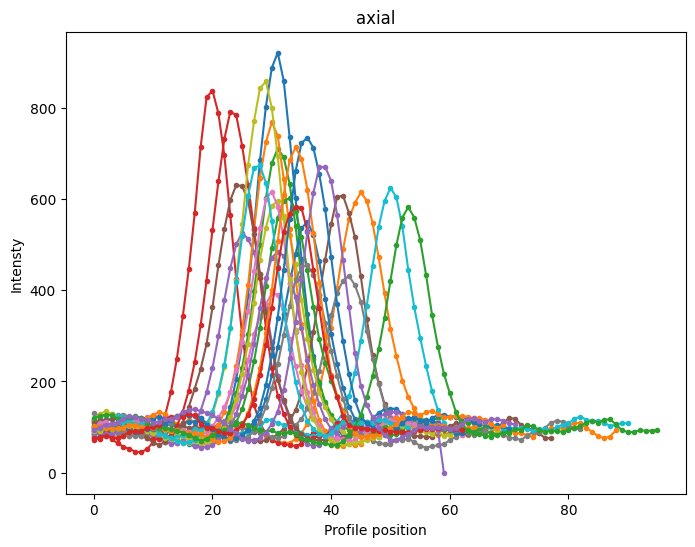

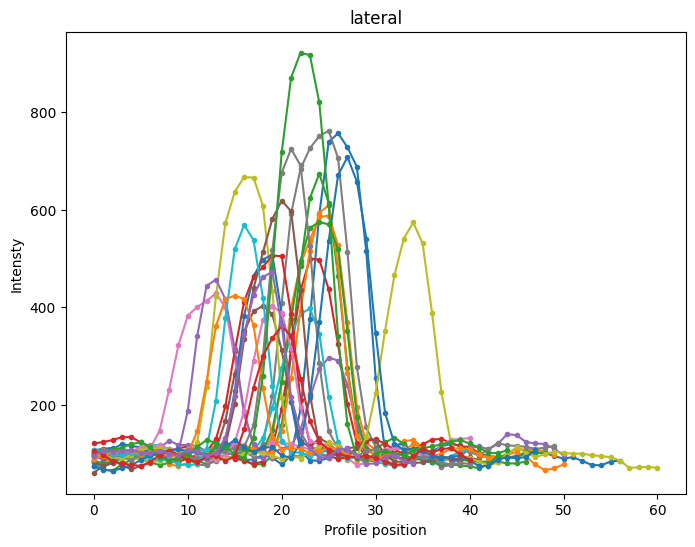

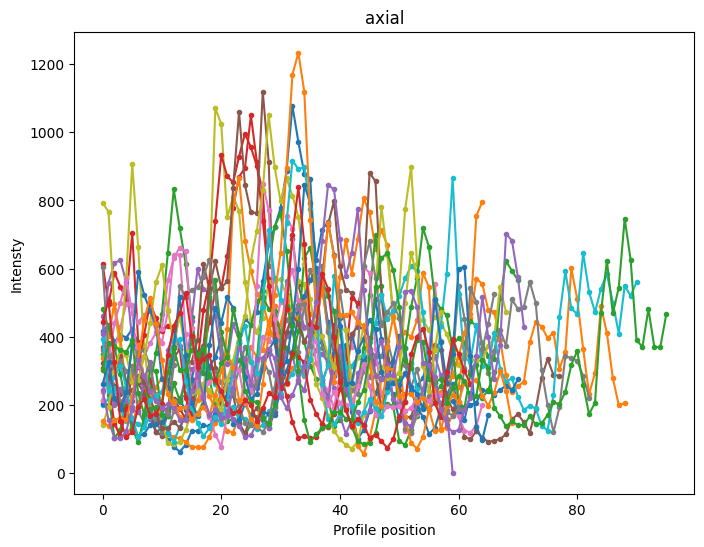

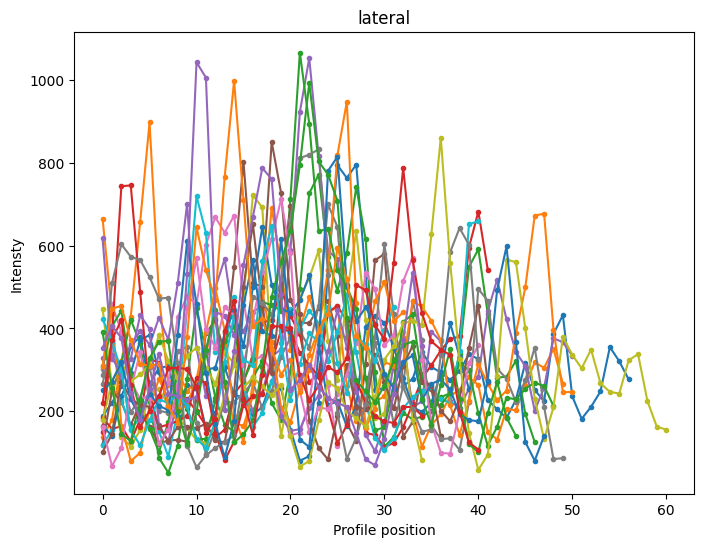

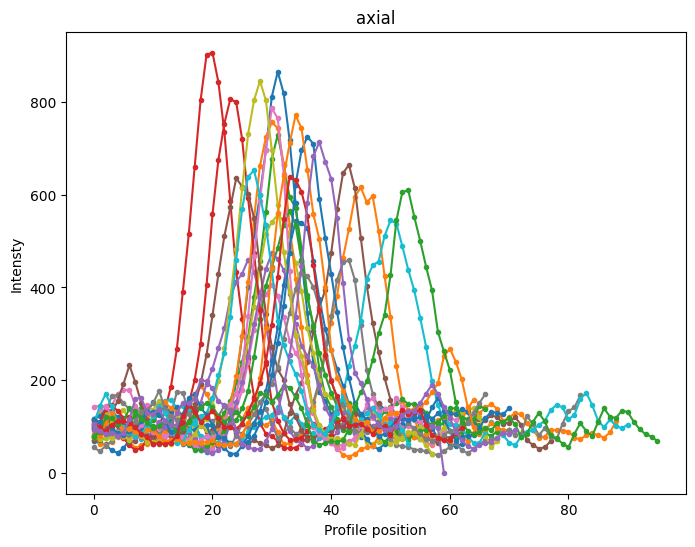

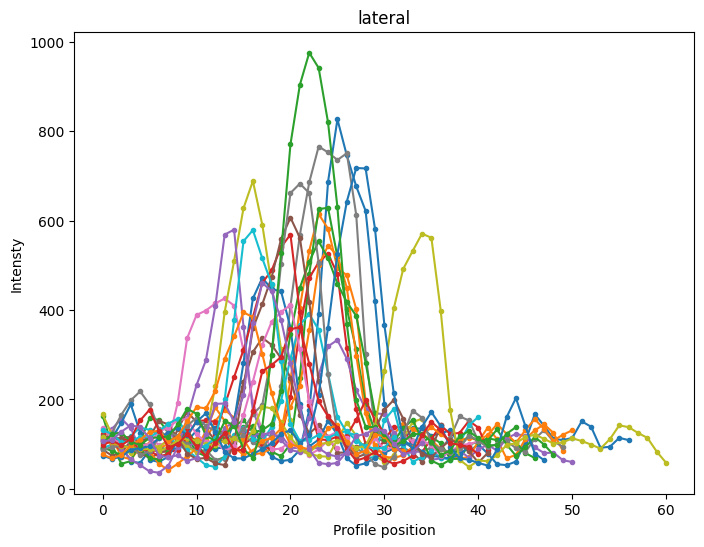

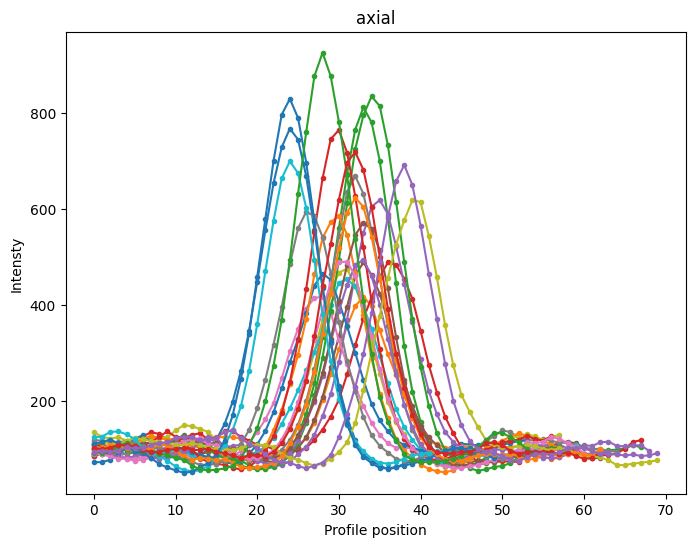

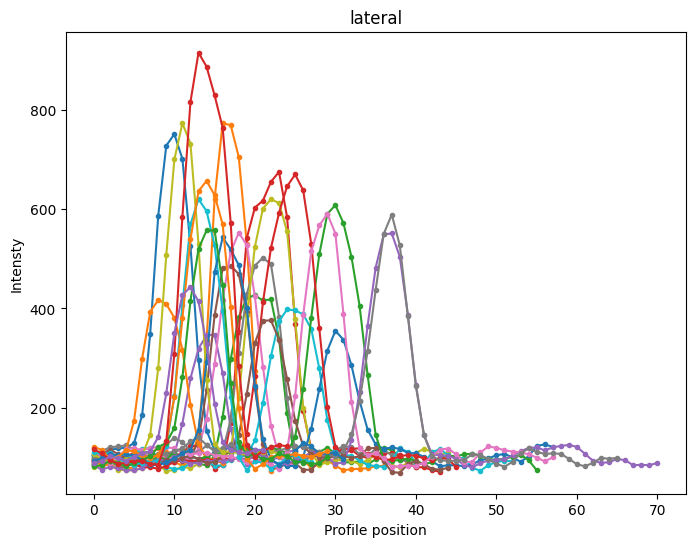

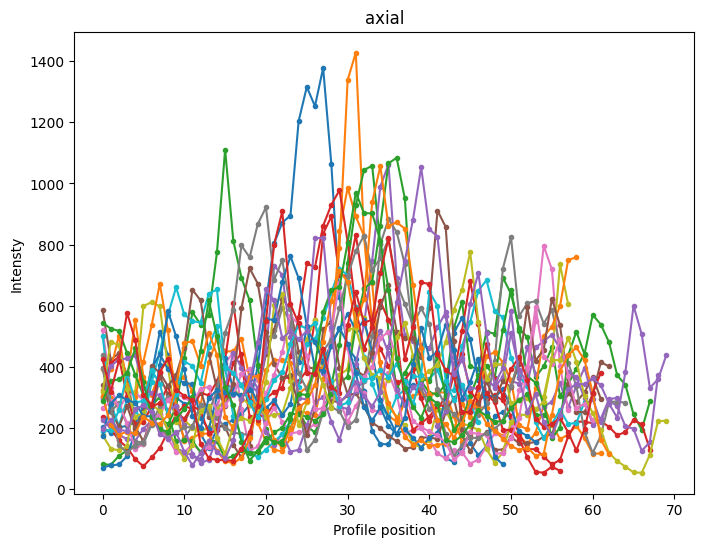

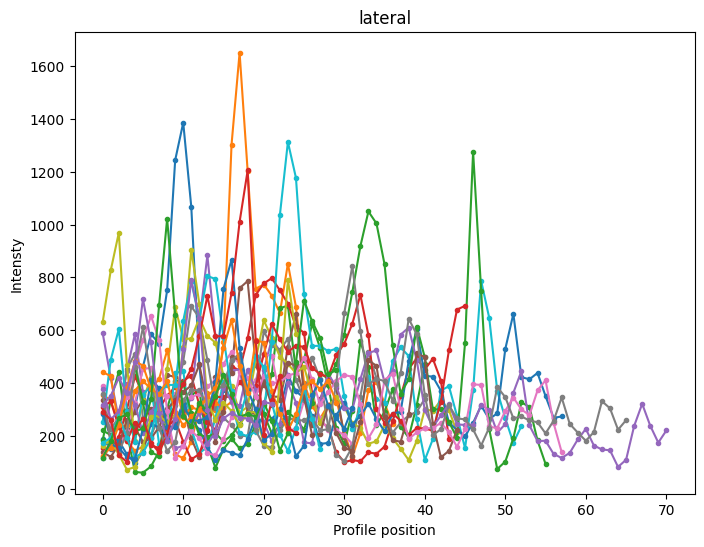

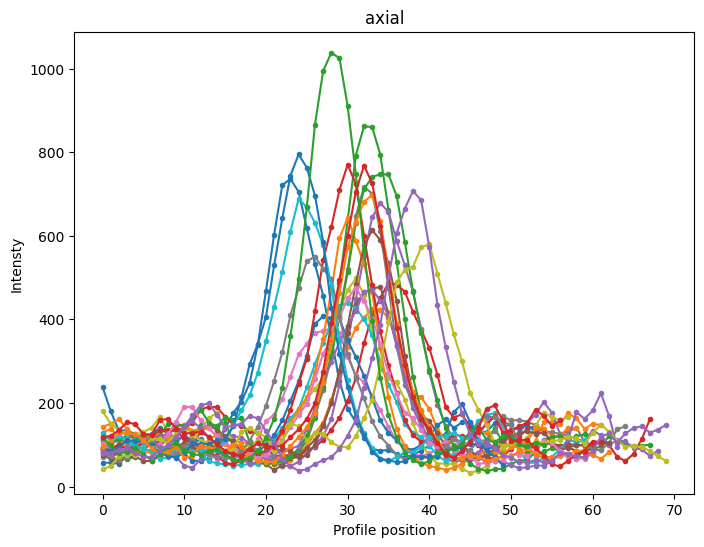

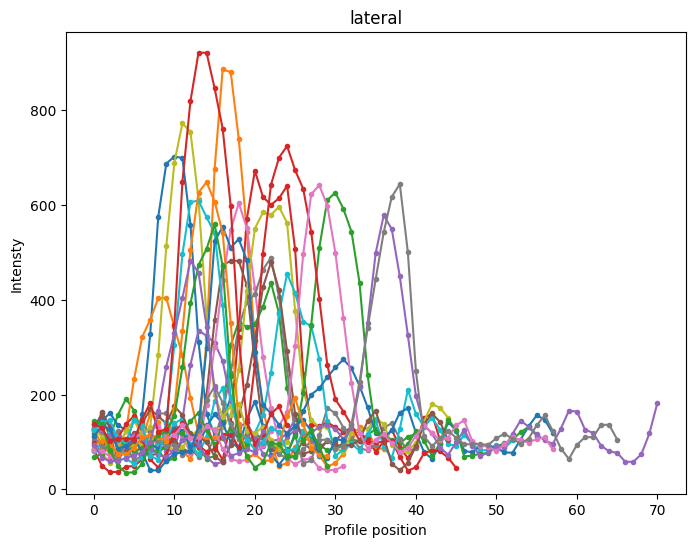

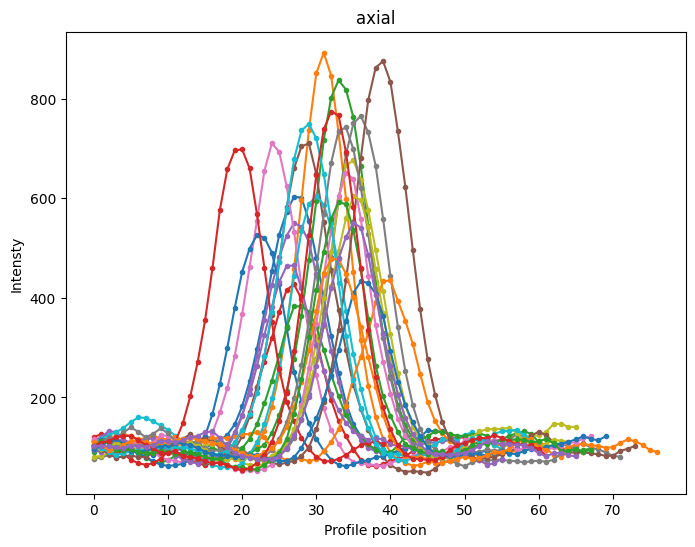

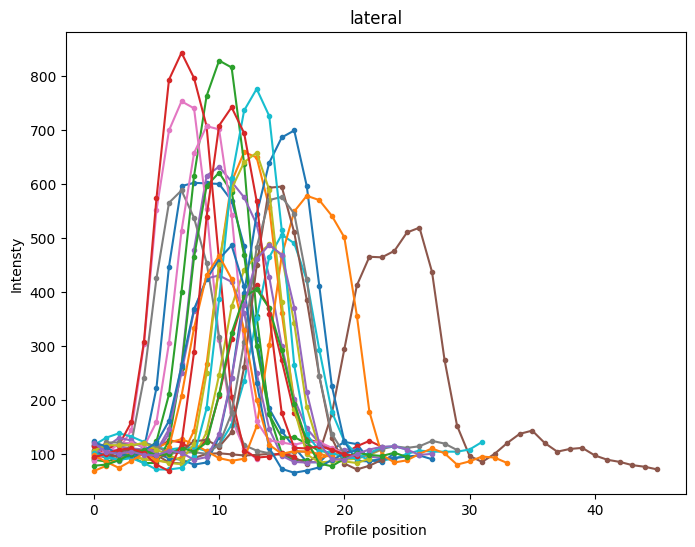

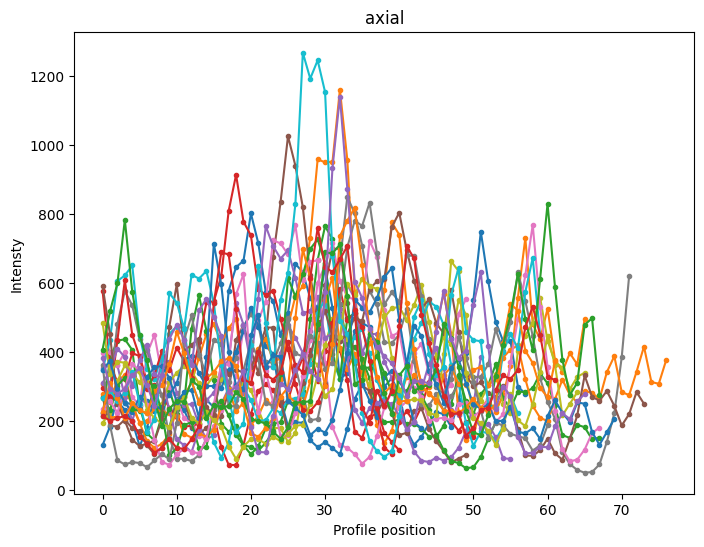

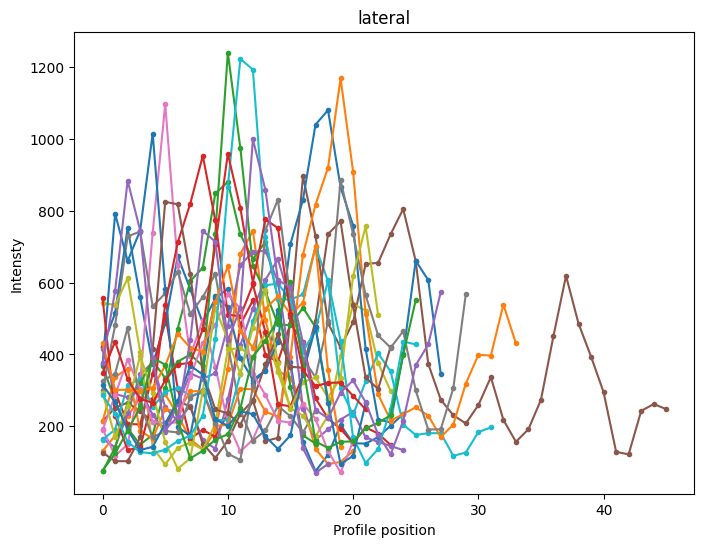

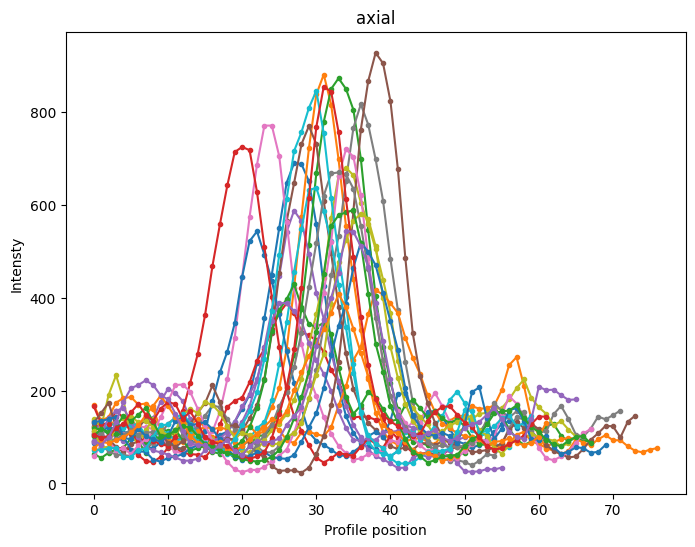

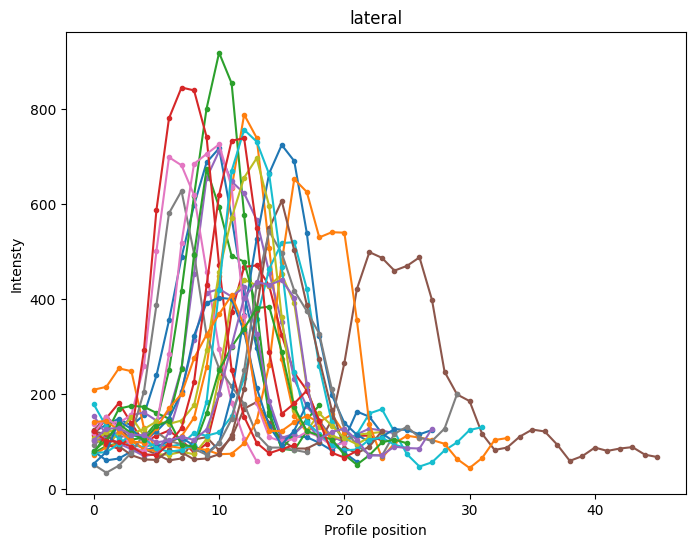

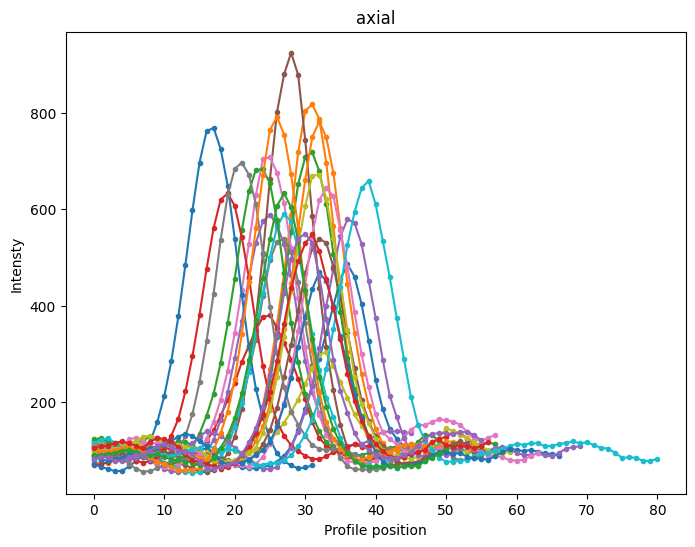

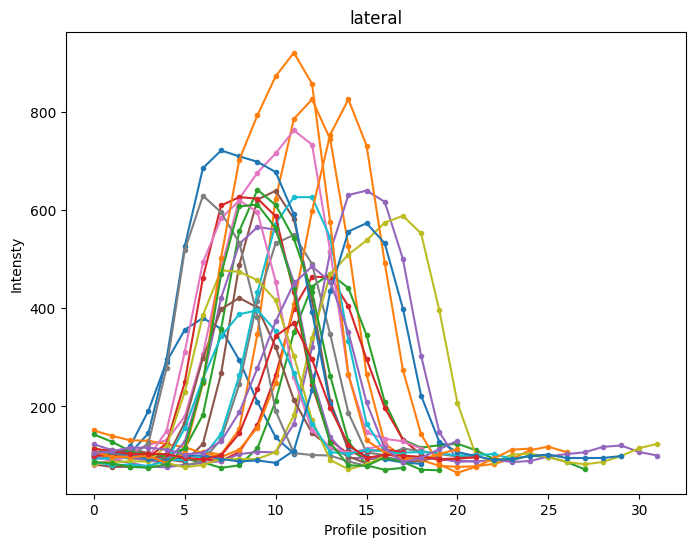

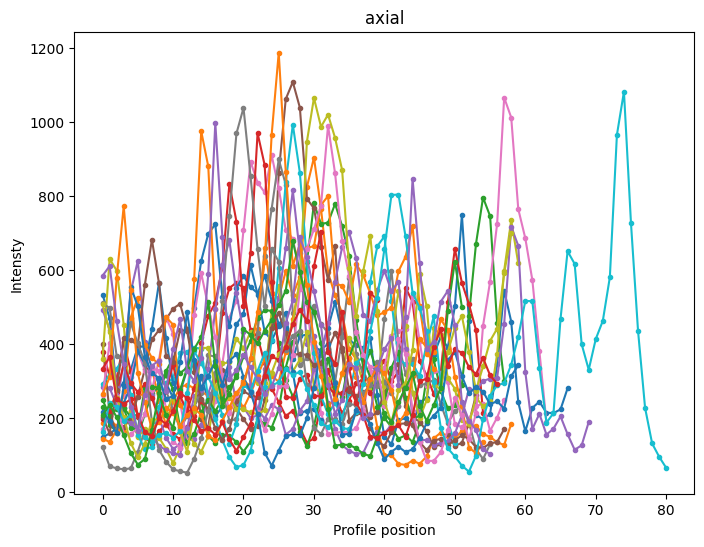

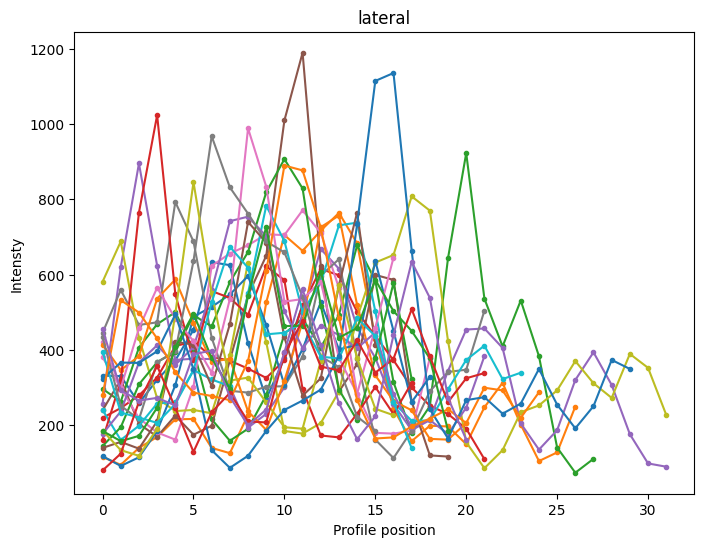

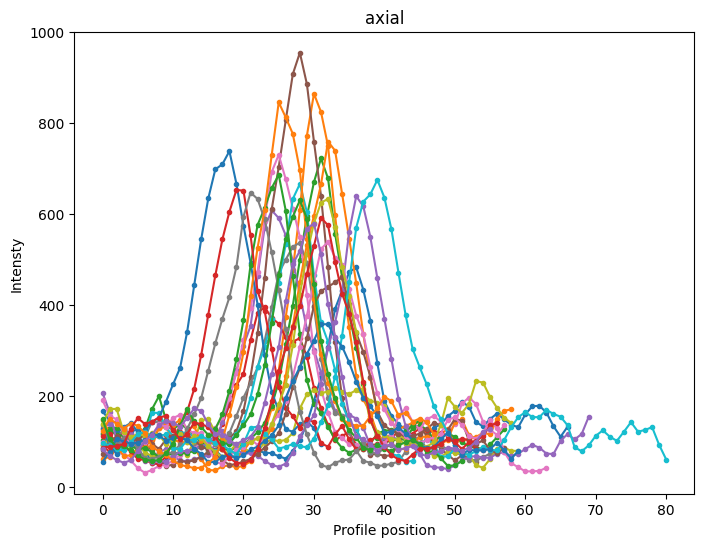

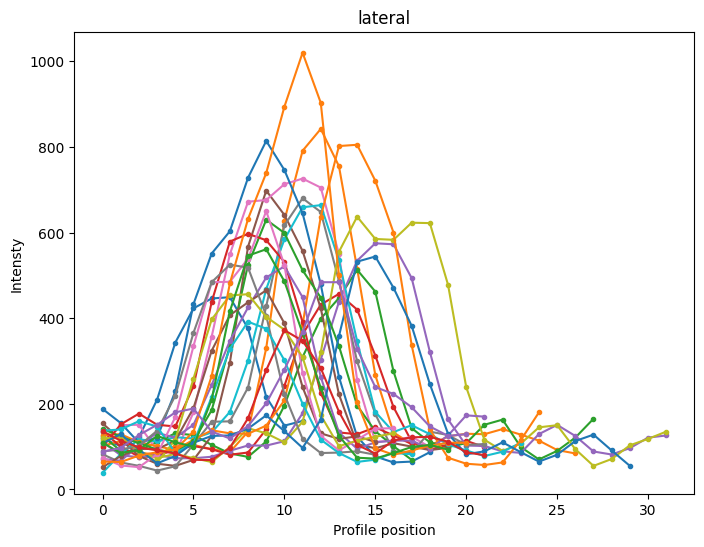

In [15]:
 base_dir = r"D:\Current_Segovia_lab\Deconvolution_Dilan\data\Deconvolution test\Evaluation\Jupyter\BC_v2\FWHM"
remove_mid_peaks = False     #Dejar en True para núcleos, False para otras estructuras (es para que ignore peaks intermedios, necesario en los núcleos)

for n in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, n)
    if not os.path.isdir(folder_path):
        continue  # Ignorar archivos

    axial_path = os.path.join(folder_path, "Axial", "procesados")
    lateral_path = os.path.join(folder_path, "Lateral", "procesados")

    if os.path.isdir(axial_path) and os.path.isdir(lateral_path):
        print(f"Procesando: {n}")
        main(axial_path, lateral_path, remove_mid_peaks)

